In [141]:
#!pip install https://github.com/ydataai/pandas-profiling/archive/master.zip
#!pip install yellowbrick
#!pip3 install scikit-learn 
import pandas as pd
import numpy  as np
from pandas_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from yellowbrick.regressor import CooksDistance
from yellowbrick.regressor import ResidualsPlot
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings("ignore")

Загрузим данные и добавим колонки:

In [144]:
df = pd.read_csv('task1.txt', sep='\t')
df.columns = [f'x_{column}' for column in range(1, 11)] + ['y']

Посмотрим описательную статистику и наличие пропусков в данных, проведем разведочных анализ данных:

In [147]:
profile = ProfileReport(df, title="Pandas Profiling Report")

In [148]:
profile.to_widgets()

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [149]:
profile.to_file("report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

- Пропущенных значений нет,
- дублирующий строк нет,
- у Х-значений равномерное распределение от 0 до 1,
- Y-значение нормальное распределение значений от 3 до 29, 
- Х признаки не зависимы друг от друга и не коррелируют между собой, 
- наблюдается похожая на линейную зависимость целевой переменной от x_1, х_2, х_4 и х_5, 
- наблюдается похожая на квадратичную зависимость целевой переменной от х_3

Построим линейную модель регрессии и оценим производительность с помощью R-squared

In [110]:
X = df.drop(['y'],axis=1)
y = df['y']
model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.7397452894984753

Построим нелинейную модель с помощью RandomForestRegressor, и оценим производительность на исходным данных с помощью R-squared.

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

X_train_std = StandardScaler().fit_transform(X_train)
X_test_std = StandardScaler().fit_transform(X_test)

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

forest = RandomForestRegressor()
_ = forest.fit(X_train_std, y_train)
forest.score(X_test_std, y_test)

0.8424226020919559

Модель объясняет 84.2% вариации целевой переменной. Попробуем улучшить результат, для начала, посмотрим на веса наших признаков:

In [31]:
pd.DataFrame(
    zip(X_train.columns, abs(forest.feature_importances_)),
    columns=["feature", "weight"],).sort_values("weight").reset_index(drop=True)

,feature,weight
0,x_7,0.009986
1,x_8,0.010508
2,x_6,0.010906
3,x_9,0.011062
4,x_10,0.011222
5,x_3,0.045794
6,x_5,0.079444
7,x_2,0.209218
8,x_1,0.252837
9,x_4,0.359024


По результатам расчета, видим то же, что мы наблюдали на графиках зависимости и по коэффициентам корреляции : самые важные признаки x_1, x_2, x_3, x_4, x_5. Воспользуемся алгоритмом RFE для удаления незначимых переменных, укажем, что хотим оставить 5 признаков, и после снова оценим производительность модели. 

In [32]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
_ = rfe.fit(X_train_std, y_train)

In [33]:
X_train.loc[:, rfe.support_]

,x_1,x_2,x_3,x_4,x_5
780,0.656209,0.750286,0.857738,0.134155,0.603643
253,0.548171,0.735595,0.381018,0.060351,0.321491
363,0.114946,0.515324,0.752938,0.923059,0.243273
803,0.028652,0.589578,0.867027,0.750823,0.132235
817,0.212419,0.128977,0.754502,0.213925,0.881621
...,...,...,...,...,...
835,0.201415,0.964013,0.764260,0.295204,0.740179
192,0.292257,0.026424,0.084598,0.686253,0.389535
629,0.110529,0.945336,0.121768,0.155891,0.573845
559,0.571496,0.733392,0.173117,0.634349,0.985520


In [34]:
forest = RandomForestRegressor()
_ = forest.fit(rfe.transform(X_train_std), y_train)
forest.score(rfe.transform(X_test_std), y_test)

0.875410359050464

Производительность улучшилась с использованием только 5 признаков. Проверим, что будет с 4: 

In [35]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=4)
_ = rfe.fit(X_train_std, y_train)
forest = RandomForestRegressor()
_ = forest.fit(rfe.transform(X_train_std), y_train)
forest.score(rfe.transform(X_test_std), y_test)

0.8049111162827217

R-squared уменьшился, остановимся на 5 признаках. Посмотрим, что с выбросами у оставшихся признаков, с помощью расстояния Кука:

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X[['x_1', 'x_2', 'x_3', 'x_4', 'x_5']], y,random_state=0)

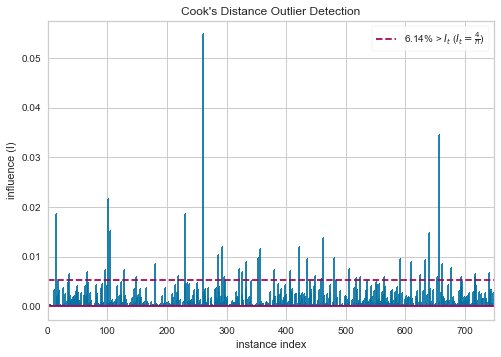

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [117]:
visualizer = CooksDistance()
visualizer.fit(X_train, y_train)
visualizer.show()

Наличие влиятельных точек говорит о том, что линейная регрессия может не подходить для этого набора данных, проверим нормальность остатков и однородность дисперсии:  

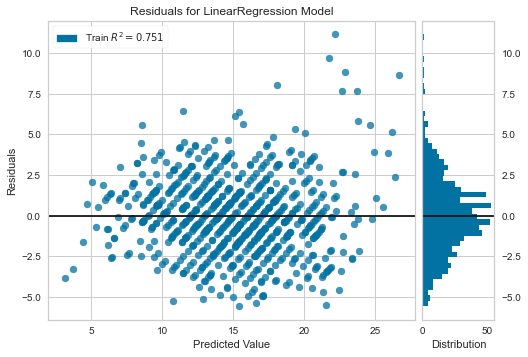

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [118]:
model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_train, y_train)
visualizer_residuals.show()

Остатки в основном около 0, но есть отклонение в положительную сторону

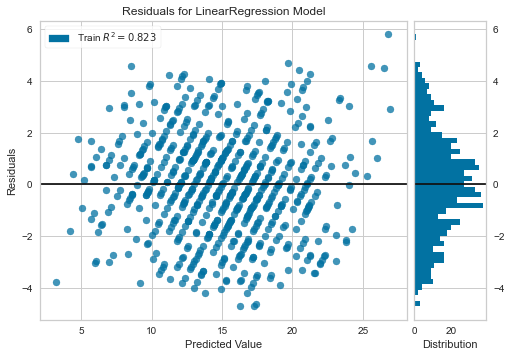

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [119]:
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
X_li, y_li = X_train[i_less_influential], y_train[i_less_influential]

model = LinearRegression()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(X_li, y_li)
visualizer_residuals.show()

Результат R-squared для линейной регрессии улучшился. Почистим датасет от выбросов. 

In [132]:
visualizer = CooksDistance()
visualizer.fit(X[['x_1', 'x_2', 'x_3', 'x_4', 'x_5']], y)
i_less_influential = (visualizer.distance_ <= visualizer.influence_threshold_)
df_li = df[i_less_influential]
df_li = df_li[['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'y']]
X_li = df_li.drop(['y'],axis=1)
y_li = df_li['y']
model = LinearRegression()
model.fit(X_li, y_li)
model.score(X_li, y_li)

0.8156752983099377

Удаление незначимых признаков и выбросов улучшило значение R-squared с 0.74 до 0.82. 
Как еще можно улучшить результат? Т.к. на графике наблюдалась квадратичная зависимость целевой переменной, попробуем построить модель с квадратами:

In [143]:
import statsmodels.formula.api as smf
est = smf.ols(formula='y ~ x_1 + x_2 + x_3 + x_4 + x_5 + np.power(x_1,2) + np.power(x_2,2) + np.power(x_3,2) + np.power(x_4,2) + np.power(x_5,2)',
              data=df_li).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     1494.
Date:                Mon, 16 May 2022   Prob (F-statistic):               0.00
Time:                        10:38:27   Log-Likelihood:                -1437.5
No. Observations:                 937   AIC:                             2897.
Df Residuals:                     926   BIC:                             2950.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1839      0.245      0.750      0.453      -0.297       0.665
x_1                 17.6716      0.503     35.146      0.000      16.685      18.658
x_2                 17.2627      0.537     32.143      0.000      16.209      18.317
x_3                -19.3855      0.538    -36.040      0.000     -20.441     -18.330
x_4                  9.8417      0.522     18.855      0.000       8.817      10.866
x_5                  4.3660      0.526      8.301      0.000       3.334       5.398
np.power(x_1, 2)   -10.0944      0.505    -19.982      0.000     -11.086      -9.103
np.power(x_2, 2)   -10.0460      0.528    -19.018      0.000     -11.083      -9.009
np.power(x_3, 2)    19.3218      0.524     36.842      0.000      18.293      20.351
np.power(x_4, 2)    -0.0622      0.503     -0.124      0.902      -1.049       0.925
np.power(x_5, 2)     0.6098      0.502      1.216      0.224      -0.374       1.594
==============================================================================
Omnibus:                       65.605   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              149.998
Skew:                           0.408   Prob(JB):                     2.68e-33
Kurtosis:                       4.782   Cond. No.                         35.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Итого, чтобы улучшить модель:  

    1. Использовать значимые переменные 'x_1', 'x_2', 'x_3', 'x_4', 'x_5',
    2. Исключить выбросы отдельных наблюдений,
    3. Использовать модель с квадратами отобранных признаков.